In [1]:
import tensorflow as tf
import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate,\
     GlobalAveragePooling2D, AveragePooling2D, Flatten
from keras.utils import np_utils
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

from matplotlib import pyplot as plt
import shutil
import os
import cv2
import imghdr
import numpy as np
import math
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
shutil.copy('/content/drive/MyDrive/Data608_Project/garbage_classification.zip', '/content/garbage-classification.zip')

'/content/garbage-classification.zip'

In [6]:
file_name = "/content/garbage-classification.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [7]:
dir = "/content/garbage_classification/"
trash_list = ['trash', 'clothes', 'battery', 'shoes']
recyc_list = ['plastic', 'brown-glass', 'white-glass', 'cans', 'cardboard', 'coffee-mugs', 'green-glass', 'metal', 'paper']
comp_list = ['biological']
for folder in os.listdir(dir):
  if folder in trash_list:
    dir_path = dir + 'trash/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in recyc_list:
    dir_path = dir + 'recyc/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)
  elif folder in comp_list:
    dir_path = dir + 'comp/'
    if not os.path.exists(dir_path):
      os.makedirs(dir_path)
    for f in os.listdir(dir+folder):
      shutil.move(dir + folder + '/' + f, dir_path + f)

for folder in os.listdir(dir):
  if folder not in ['trash', 'recyc', 'comp']:
    os.rmdir(dir + folder)
  else:
    path = dir + folder + '/'
    for file in os.listdir(path):
        if file.endswith('.jpg') or file.endswith('.JPG'):
            img = cv2.imread(path+str(file))
            cv2.imwrite(path+file[0:-4]+'.jpeg', img)
            os.remove(path+file)

In [8]:
num_classes = len(list(os.listdir(dir)))
print(f'There are {num_classes} classes to classify')

There are 3 classes to classify


In [9]:
images = []
labels = []
for img, label in tf.keras.utils.image_dataset_from_directory(directory='/content/garbage_classification', 
                                                              labels='inferred',
                                                              label_mode = 'int',
                                                              batch_size=None,
                                                              image_size=(128, 128)).take(-1).as_numpy_iterator():
  images.append(img)
  labels.append(label)

Found 16234 files belonging to 3 classes.


In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size = 0.8, random_state = 156, stratify= labels)
del images, labels

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size = 0.75, random_state = 165, stratify= y_train)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
x_valid = np.array(x_test) / 255.0

In [11]:
len(x_train), len(x_valid), len(x_test), len(y_train), len(y_valid), len(y_test)

(9740, 3247, 3247, 9740, 3247, 3247)

In [12]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [13]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [14]:
input_layer = Input(shape=(128, 128, 3))

x = Conv2D(64, (7, 7), 
           padding='same', 
           strides=(2, 2), 
           activation='relu', 
           name='conv_1_7x7/2', 
           kernel_initializer=kernel_init, 
           bias_initializer=bias_init)(input_layer)

x = MaxPool2D((3, 3), 
              padding='same', 
              strides=(2, 2), 
              name='max_pool_1_3x3/2')(x)

x = Conv2D(64, (1, 1), 
           padding='same', 
           strides=(1, 1), 
           activation='relu', 
           name='conv_2a_3x3/1')(x)

x = Conv2D(192, (3, 3), 
           padding='same', 
           strides=(1, 1), 
           activation='relu', 
           name='conv_2b_3x3/1')(x)

x = MaxPool2D((3, 3), 
              padding='same', 
              strides=(2, 2), 
              name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), 
                      strides=3)(x)

x1 = Conv2D(128, (1, 1), 
            padding='same', 
            activation='relu')(x1)

x1 = Flatten()(x1)
x1 = Dense(1024, 
           activation='relu')(x1)

x1 = Dropout(0.7)(x1)

x1 = Dense(num_classes, 
           activation='softmax', 
           name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), 
                      strides=3)(x)

x2 = Conv2D(128, (1, 1), 
            padding='same', 
            activation='relu')(x2)

x2 = Flatten()(x2)
x2 = Dense(1024, 
           activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(num_classes, 
           activation='softmax', 
           name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), 
              padding='same', 
              strides=(2, 2), 
              name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(num_classes, activation='softmax', name='output')(x)

In [15]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [16]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 64, 64, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                                
                                                                                       

In [17]:
epochs = 35
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, 
          momentum=0.9, 
          nesterov=False)

lr_sc = LearningRateScheduler(decay, 
                              verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], 
              optimizer=sgd, 
              metrics=['accuracy'])

In [18]:
history = model.fit(x_train, 
                    [y_train, y_train, y_train], 
                    validation_data=(x_valid, 
                                     [y_valid, y_valid, y_valid]), 
                    epochs=epochs, 
                    batch_size=256, 
                    callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/35
39/39 [==============================] - 42s 518ms/step - loss: 1.5158 - output_loss: 0.9490 - auxilliary_output_1_loss: 0.9365 - auxilliary_output_2_loss: 0.9530 - output_accuracy: 0.5167 - auxilliary_output_1_accuracy: 0.5244 - auxilliary_output_2_accuracy: 0.5073 - val_loss: 1.4809 - val_output_loss: 0.9343 - val_auxilliary_output_1_loss: 0.9150 - val_auxilliary_output_2_loss: 0.9070 - val_output_accuracy: 0.5510 - val_auxilliary_output_1_accuracy: 0.5510 - val_auxilliary_output_2_accuracy: 0.5510 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/35
39/39 [==============================] - 13s 329ms/step - loss: 1.4271 - output_loss: 0.8947 - auxilliary_output_1_loss: 0.8824 - auxilliary_output_2_loss: 0.8922 - output_accuracy: 0.5521 - auxilliary_output_1_accuracy: 0.5640 - auxilliary_output_2_accuracy: 0.5562 - val_loss: 1.6779 - val_output_loss: 1.0554 - val_auxilliary_outp

In [19]:
loss, output_loss, auxilliary_output_1_loss, auxilliary_output_2_loss, output_accuracy, auxilliary_output_1_accuracy, auxilliary_output_2_accuracy = model.evaluate(x_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', output_accuracy)

102/102 [==============================] - 5s 27ms/step - loss: 0.7136 - output_loss: 0.4473 - auxilliary_output_1_loss: 0.4467 - auxilliary_output_2_loss: 0.4411 - output_accuracy: 0.8174 - auxilliary_output_1_accuracy: 0.8143 - auxilliary_output_2_accuracy: 0.8217

test loss:  0.7136191129684448

test accuracy:  0.8173698782920837


Saving biological186.jpg to biological186.jpg
1/1 [==============================] - 0s 29ms/step


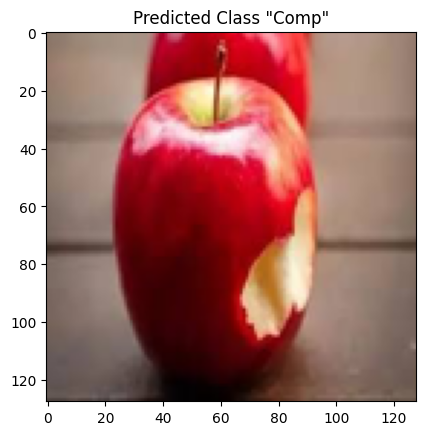

In [31]:
import imageio
from PIL import Image
from google.colab import files

uploaded = files.upload()
f_name = [str(key) for key in uploaded.keys()][0]

labels = ['Comp', 'Recyc', 'Trash']

img = imageio.imread(f'/content/{f_name}', pilmode='RGB')
img = np.array(Image.fromarray(img).resize((128, 128))).astype(np.float32)
resized = img/255
resized = np.expand_dims(img, axis=0)

# Test pretrained model
out = model.predict(resized) # note: the model has three outputs
predicted_label = np.argmax(out[2])
predicted_class_name = labels[predicted_label]

plt.imshow(img.astype(int))
plt.title(f'Predicted Class "{predicted_class_name}"')
plt.show()

In [28]:
model.save('GoogleNet_3Class_Data2.h5')

In [29]:
files.download('GoogleNet_3Class_Data2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>